In [1]:
gc()
rm(list=ls())

if (!require(pacman)) install.packages("pacman")
library(pacman)

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,960177,51.3,1950321,104.2,1249132,66.8
Vcells,1703236,13.0,8388608,64.0,2651364,20.3


Loading required package: pacman



In [2]:
pacman::p_load(tidyverse,
               readxl, 
               chilemapas,
               sjmisc,
               summarytools,
               htmlTable,
               httr,
               texreg,
               knitr,
               kableExtra,
               gridExtra,
               stringr)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


chilemapas installed



# **Tarea 2**

Profesor José Conejeros

Estudiantes Mario Bravo y Enzo Loiza


## Ejercicio 1

La infección por Hantavirus, cuya mayor expresión de gravedad es el Síndrome Cardiopulmonar (SCPH), es una zoonosis endémica de Chile causada por el virus Andes (ANDV). El ANDV es un virus de genoma ARN segmentado y con envoltura lipídica, miembro del género Orthohantavirus y la familia Hantaviridae. Este virus tiene como reservorio natural el roedor Oligoryzomys longicaudatus conocido como “ratón colilargo o cola larga”, cuyo hábitat se encuentra distribuido desde el valle de Copiapó en la III Región a Campos de Hielo Sur (50° S).

El ministerio de salud le encarga a usted realizar un análisis descriptivo de la situación histórica de los casos de hantavirus y entregar recomendaciones para una mejor atención y control. Para esto usted trabajara con la tabla de datos Hantavirus_chile.xlsx que cuenta con el registro histórico de casos identificados de esta infección. A partir de esto se le pide realizar las siguientes tareas:

a. Importe su tabla de datos e indique cuántas infecciones por Hantavirus se han registrado a la fecha. Explique cuál es la unidad de análisis de estos datos ¿La tabla esta compuesta por personas únicas o hay duplicados? Explique que sería un duplicado en este caso. (0.5 puntos)

In [3]:
db <- read_excel('../input/hantavirus-chile/Hantavirus_chile.xlsx')

In [4]:
glimpse(db)

Rows: 1,293
Columns: 10
$ fecha_notificacion       <dttm> 2022-01-07, 2021-12-30, 2021-12-30, 2021-12-…
$ fecha_primeros_sintomas  <dttm> 2021-12-30, 2021-12-27, 2021-12-22, 2021-12-…
$ sexo                     <chr> "hombre", "hombre", "hombre", "hombre", "homb…
$ edad_cat                 <chr> "20-24", "40-44", "35-39", "25-29", "15-19", …
$ seremi_notificacion      <chr> "SEREMI Del Nuble", "SEREMI Del Libertador Gr…
$ region_residencia        <chr> "Region del Nuble", "Region del Libertador Ge…
$ comuna_residencia        <chr> "Chillan", "Pichidegua", "Los Muermos", "Mulc…
$ cie_10_diagnostico       <chr> "B33.4", "B33.4", "B33.4", "B33.4", "B33.4", …
$ diagnostico              <chr> "Síndrome pulmonar por hantavirus", "Síndrome…
$ region_probable_contagio <chr> "Región del Ñuble", "Región del Libertador Ge…


Unidad de análisis: el caso de infección por Hantavirus.


In [5]:
unicos <- c('fecha_notificacion',
            'fecha_primeros_sintomas',
            'sexo',
            'edad_cat',
            'seremi_notificacion',
            'region_residencia',
            'comuna_residencia',
            'cie_10_diagnostico',
            'diagnostico',
            'region_probable_contagio')

duplicados <- db[duplicated(db[, unicos]), ]

if (nrow(duplicados) == 0) {
  cat("No se encontraron duplicados en la tabla.")
} else {
  cat("Se encontraron duplicados en la tabla.")
  duplicados
}

Se encontraron duplicados en la tabla.

fecha_notificacion,fecha_primeros_sintomas,sexo,edad_cat,seremi_notificacion,region_residencia,comuna_residencia,cie_10_diagnostico,diagnostico,region_probable_contagio
<dttm>,<dttm>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
2006-09-14,2006-09-11,mujer,25-29,SEREMI De Valparaiso,Region de Valparaiso,Valparaiso,B33.4,Síndrome pulmonar por hantavirus,Región de Valparaíso


La tabla no tiene información personal, por lo que es posible que aparezca una persona que se enfermó dos veces.

Un duplicado sería a mi parecer, un caso reportado dos veces.

b. Construya dos tablas con los porcentajes de 1) infecciones de hantavirus por año desagregado por sexo y 2) infecciones de hantavirus por año desagregado por grupo etarios. ¿Qué le podría comentar al Ministerio de Salud respecto a sus resultados?

In [6]:
#creamos una columna con el año
db$year <- lubridate::year(db$fecha_notificacion)

resumen1 <- db %>%
    group_by(year, sexo) %>%
    summarize(N = n()) %>%
    ungroup() %>%
    group_by(year) %>%
    mutate(porcentaje = N / sum(N) * 100) %>%
    ungroup()
colnames(resumen1) <- c("año", "sexo", "N", "porcentaje")
resumen1

`summarise()` has grouped output by 'year'. You can override using the
`.groups` argument.


año,sexo,N,porcentaje
<dbl>,<chr>,<int>,<dbl>
1995,mujer,1,100.00000
1996,hombre,3,100.00000
1997,hombre,21,77.77778
1997,mujer,6,22.22222
1998,hombre,28,73.68421
1998,mujer,10,26.31579
1999,hombre,18,72.00000
1999,mujer,7,28.00000
2000,hombre,23,82.14286


In [7]:
resumen1 <- db %>%
    group_by(year, edad_cat) %>%
    summarize(N = n()) %>%
    ungroup() %>%
    group_by(year) %>%
    mutate(porcentaje = N / sum(N) * 100) %>%
    ungroup()
colnames(resumen1) <- c("año", "sexo", "N", "porcentaje")
resumen1

`summarise()` has grouped output by 'year'. You can override using the
`.groups` argument.


año,sexo,N,porcentaje
<dbl>,<chr>,<int>,<dbl>
1995,20-24,1,100.000000
1996,20-24,1,33.333333
1996,25-29,1,33.333333
1996,30-34,1,33.333333
1997,0-4,1,3.703704
1997,10-14,3,11.111111
1997,15-19,1,3.703704
1997,20-24,2,7.407407
1997,25-29,2,7.407407


Comentarios pendientes

c. Construya una tabla con el número de casos por región (`region_residencia`) agrupando cada 5 años. Indique la región con el mayor cantidad de casos en el tiempo y realice un zoom para identificar las comunas más críticas (mayor número de casos totales) para esa región ¿Qué input relevante le podría indicar al Ministerio de Salud? ¿Dónde podríamos tener una mayor vigilancia?

## Ejercicio 2
En el ejercicio 1 se le pidió realizar una extracción desde la API del Banco Mundial y realizar análisis
a partir de su extracción. En este caso, usted trabajará con la siguiente extracción de la API que
corresponde al ingreso per cápita (GDP) para América Latina y el Caribe solo para el año 2020.


In [8]:
library(WDI)
gdp <- WDI(country = 'all',
          indicator = 'NY.GDP.PCAP.PP.KD',
          start = 2015,
          end = 2020,
          extra = TRUE,
          cache = NULL,
          latest = NULL,
          language = 'es') %>%
    filter(region == 'Latin America & Caribbean' & year == 2020)

Usted debería tener una tabla con las siguientes columnas:

In [9]:
glimpse(gdp)

Rows: 22
Columns: 13
$ country           <chr> "Argentina", "Aruba", "Barbados", "Bolivia", "Chile"…
$ iso2c             <chr> "AR", "AW", "BB", "BO", "CL", "CO", "CR", "CU", "CW"…
$ iso3c             <chr> "ARG", "ABW", "BRB", "BOL", "CHL", "COL", "CRI", "CU…
$ year              <int> 2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020…
$ NY.GDP.PCAP.PP.KD <dbl> 19685.216, 33155.243, 13805.778, 7679.933, 22970.550…
$ status            <chr> "", "", "", "", "", "", "", "", "", "", "", "", "", …
$ lastupdated       <chr> "2023-07-25", "2023-07-25", "2023-07-25", "2023-07-2…
$ region            <chr> "Latin America & Caribbean", "Latin America & Caribb…
$ capital           <chr> "Buenos Aires", "Oranjestad", "Bridgetown", "La Paz"…
$ longitude         <chr> "-58.4173", "-70.0167", "-59.6105", "-66.1936", "-70…
$ latitude          <chr> "-34.6118", "12.5167", "13.0935", "-13.9908", "-33.4…
$ income            <chr> "Upper middle income", "High income", "High income",…
$ lending          

Además usted sabe que el promedio del GDP para los países en el 2020 es de:

In [10]:
mean(gdp$NY.GDP.PCAP.PP.KD, na.rm = TRUE)

[1] 16154.51

A continuación se realiza el siguiente flujo empaquetado en una función llamada `muestreo`:

In [11]:
muestreo <- function(v, m, n, replace = TRUE){
    library(dplyr)                                #cargar las librerias
    library(ggplot2)
    library(patchwork)
    
    vector_promedios <- c()                       
    for (i in 1:m) {
        muestra <- sample(x = v,
                         size = n,
                         replace = TRUE)
        vector_promedios[i] <- mean(muestra, na.rm = TRUE)
    }

    promedio <- mean(vector_promedios, na.rm = TRUE)

    g1 <- ggplot(data = NULL, aes(x = 1:m, y = vector_promedios)) +
        geom_point(color = "darkblue") + geom_line(color = "blue") +
        geom_hline(yintercept = mean(v, na.rm=TRUE), color = "red", lwd = 1) + #Promedio real
        geom_hline(yintercept = promedio, color = "green", lwd = 1) #Gran media

    g2 <- ggplot(data = NULL, aes(x = vector_promedios)) +
        geom_histogram(bins = 100, fill="darkblue") +
        geom_vline(xintercept = mean(v, na.rm=TRUE), color = "red", lwd = 1) +
        geom_vline(xintercept = promedio, color = "green", lwd = 1)

    grafico <- g1/g2

    print(paste0("Promedios de ", m, " muetras de tamaño ", n, ":"))
    print(vector_promedios)
    print(paste0("Promedio de promedios (Gran media): ", promedio))
    print(paste0("Promedio 'verdadero': ", mean(v, na.rm=TRUE)))
    print(grafico)
}


Utilizando la función `muestreo()` podemos obtener los siguientes resultados:

[1] "Promedios de 200 muetras de tamaño 5:"
  [1] 16691.435 20259.481 13529.268 15002.587 16215.854 17929.886 13592.690
  [8] 17056.667 23579.314 14333.069  9598.558 13712.556 24978.245 12121.582
 [15] 17841.382 12063.205 14158.887 11368.598 20304.396 10784.606 10839.610
 [22] 14700.222 18163.120 11656.511 30191.093 20068.323 18037.546 16893.695
 [29] 20097.029 10112.589 12222.213 12846.905 12045.515 21504.816 14075.752
 [36] 13591.880 11701.716  7883.859 21097.263 18672.942 20841.618 12594.151
 [43] 10794.435 21206.726 20773.002  9543.407 12106.635 16903.583 15273.617
 [50] 17830.095 16009.857 13584.833 21399.535 13433.591 16137.976 15348.742
 [57] 18286.068 19857.025 14510.221 20991.385 20387.514 12139.348 19749.717
 [64]  9311.910 11110.075 15561.531 15418.059 14694.962 15457.820 13157.528
 [71] 21133.049 18360.427 20144.590 21290.456 12114.751 12960.447 17883.347
 [78] 14046.725 21920.114 16149.780 10830.329 18696.035 12574.575 16047.753
 [85] 18698.023 19508.153 17055.469 21111.18

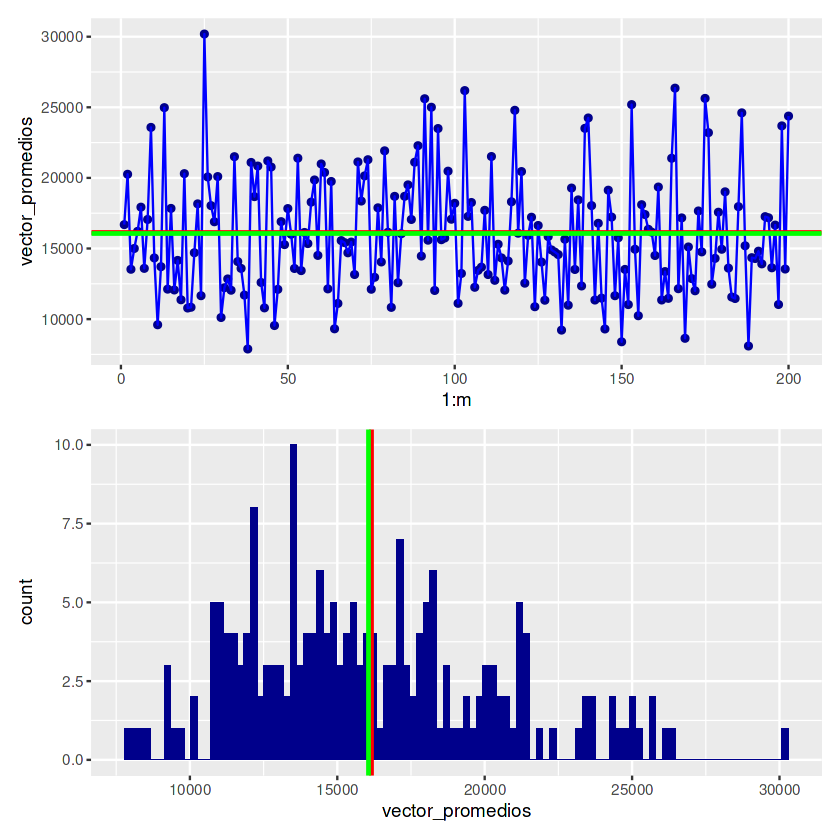

In [12]:
muestreo(v=gdp$NY.GDP.PCAP.PP.KD, m=200, n=5, replace = TRUE)

A partir de la función muestreo() y el análisis detallado resuelva lo siguiente:

a. Describa lo que realiza la función. ¿Cuál es el objetivo de aplicar este proceso sobre los datos? (0.5 puntos)

b. Explique en qué consisten los inputs `v`, `m`, `n` y `replace = TRUE` de la función propuesta. (0.5 puntos)

c. Interprete las dos figuras que se generan a partir de este flujo. (0.5 puntos)

d. ¿En qué se diferencian de forma conceptual la “gran media” de la “media verdadera”? Explique e interprete el resultado obtenido. (0.5 puntos)


## Bonus
Utilizando la tabla de datos `Hantavirus_chile.xlsx`, genere cualquiera de los dos inputs solicitados a continuación (solo 1) y entregue una breve lectura de sus resultados. Sea breve, simple y con un lenguaje directo.

**Input 1**: Gráficos de líneas con la serie temporal para el número de casos de Hantavirus según año-mes. Presente una primera serie general para todos los datos y luego otra figura con las series desagregadas por grupo etario. Utilice la variable fecha_notificacion para construir sus series.

**Input 2**: Realice mapas de Chile con el número de casos de hantavirus por región o comuna (usted decide que es mejor). Estos mapas deben ser desagregados por períodos:

- Un mapa para el número de casos entre 1995 - 2004
- Un mapa para el número de casos entre 2005 - 2014
- Un mapa para el número de casos entre 2015 - 2022

Para esto se puede apoyar de la librería `sf` y `chilemapas`.

